In [33]:
from Mc2PCA_class import Mc2PCA
import numpy as np
from sktime.datasets import load_japanese_vowels
import matplotlib.pyplot as plt 
import pandas as pd
# import train_test_split


In [78]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, classes):
    # Aligner les étiquettes de cluster avec les vraies étiquettes
    labels = np.zeros_like(y_pred)
    for i in range(max(y_pred) + 1):
        mask = (y_pred == i)
        if np.sum(mask) > 0:
            # Trouver le mode en utilisant np.unique
            unique, counts = np.unique(y_true[mask], return_counts=True)
            labels[mask] = unique[np.argmax(counts)]

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_true, labels)
    # print(conf_matrix)

    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=classes, yticklabels=classes)
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.show()

def compute_precision(C, G):
    """
    Compute the precision of clustering as described in the provided formula.
    
    C is a list of numpy arrays, where each array represents the indices of MTS objects in the jth predicted cluster.
    G is a list of sets, where each set contains the indices of MTS objects in the ith true group.
    
    Parameters:
    - C: A list of numpy arrays representing the predicted clusters.
    - G: A list of sets representing the true groups.
    
    Returns:
    - The precision of the clustering.
    """
    N = sum(len(c) for c in C)  # Total number of MTS objects
    precision = 0.0
    
    for cj in C:
        cj_set = set(cj)
        max_intersection = max(len(cj_set.intersection(gi)) for gi in G)
        # if len(cj) == 0:
        #     continue  # Ignore les clusters vides
        precision += (len(cj) / N) * (max_intersection / len(cj))
        
    return precision

def compute_recall(C, G):
    """
    Compute the recall of clustering.
    
    C is a list of numpy arrays, where each array represents the indices of MTS objects in the jth predicted cluster.
    G is a list of sets, where each set contains the indices of MTS objects in the ith true group.
    
    Parameters:
    - C: A list of numpy arrays representing the predicted clusters.
    - G: A list of sets representing the true groups.
    
    Returns:
    - The recall of the clustering.
    """
    N = sum(len(g) for g in G)  # Total number of MTS objects
    recall = 0.0
    
    for gi in G:
        gi_set = set(gi)
        max_intersection = max(len(gi_set.intersection(cj)) for cj in C)
        recall += (len(gi) / N) * (max_intersection / len(gi))
        
    return recall

def get_p_max(X, K, y_test, metric = "precision", seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array

    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    y_estimate = None
    val = np.inf
    values = []
    p_opt = 0
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        idx_estimate, _, _ = model.fit(X)
        if metric=="precision":
            precision = compute_precision(idx_estimate, idx_test)
            values.append(precision)
        if metric=="ARI":
            y_estimate = np.arange(len(y_test))
            for i in range(len(idx_estimate)):
                y_estimate[idx_estimate[i]] = i + 1 
            ari_score = adjusted_rand_score(y_test.astype(int), y_estimate)
            values.append(ari_score)
    values = np.array(values)
    return np.argmax(values) + 1, values

def get_p_histo(X, K, y_test, seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array
    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    y_estimate = None
    val = np.inf
    precisions = []
    aris = []
    p_opt = 0
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        idx_estimate, _, _ = model.fit(X)
        y_estimate = np.arange(len(y_test))
        for i in range(len(idx_estimate)):
            y_estimate[idx_estimate[i]] = i + 1
        precisions.append(compute_precision(idx_estimate, idx_test))
        aris.append(adjusted_rand_score(y_test.astype(int), y_estimate))
    return precisions, aris

def plot_info(X, K, seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array
    info_tot = []
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        _, _, info_by_cluster = model.fit(X)
        info_tot.append(info_by_cluster)
    plt.figure(figsize=(10, 7))
    info_tot = np.array(info_tot)
    for i in range(K):
        # cum_sum = [sum(info_tot[i][:j+1])  for j in range(len(info_tot[i]))]
        plt.plot(np.arange(1, nbre_features), info_tot[:, i], label = "Cluster " + str(i+1), marker = 'x')
    plt.legend()
    # Ecris les légendes et le titre en anglais 
    plt.title("Cumulative Information for each cluster for different p")
    plt.xlabel("Number of p for Mc2PCA")
    plt.ylabel("Information")
    plt.xticks(np.arange(1, nbre_features))
    plt.show()
    
def plot_hist(X, K, y_test, seuil = 1e-7, max_iter = 50):
    precisions, aris = get_p_histo(X, K, y_test, seuil = 1e-7, max_iter = 50)
    # Positions des barres sur l'axe des abscisses
    x = np.arange(1, len(precisions) + 1)

    # Largeur des barres
    bar_width = 0.35

    # Création des barres
    plt.bar(x - bar_width/2, precisions, width=bar_width, label='Precision')
    plt.bar(x + bar_width/2, aris, width=bar_width, label='ARI')

    # Ajout d'étiquettes et de légendes
    plt.xlabel('Number of p for Mc2PCA')
    plt.title('Comparison of Precision and ARI for different p')
    plt.xticks(x, [str(i) for i in x])
    plt.legend()

    # Afficher le graphique
    plt.show()
    return precisions, aris

def metrics(y_test, idx_estimate,plot=False):
    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    # Conversion des indices en classes
    y_estimate = np.arange(len(y_test))
    for i in range(len(idx_estimate)):
        y_estimate[idx_estimate[i]] = i + 1 


    # Calcul de l'ARI
    ari_score = adjusted_rand_score(y_test.astype(int), y_estimate)


    # Calcul de la précision
    precision = compute_precision(idx_estimate, idx_test)
   

    recall = compute_recall(idx_estimate, idx_test)
    if(plot):
        print("Adjusted Rand Index:", ari_score) 
        print("Precision:", precision)
        print("Recall:", recall)
        # print("varie entre -1 et 1, 1 indique une correspondance parfaite, 0 indique une correspondance aléatoire et -1 indique une correspondance complètement incorrecte")

        plot_confusion_matrix(y_test.astype(int), y_estimate, classes = np.arange(1, np.max(y_test.astype(int) + 1)))
        plt.show()
    return ari_score,precision,recall

In [92]:
X_test, y_test = load_japanese_vowels(return_X_y=True, split="train")
X_train, y_train = load_japanese_vowels(return_X_y=True, split="test")
np.random.seed(0)
# # shuffle rows
X_train = X_train.sample(frac=1)
y_train = y_train[X_train.index]

In [93]:
Epsilon = np.empty_like(X_train)
for i in range(Epsilon.shape[0]):
    for j in range(Epsilon.shape[1]):
        moy = X_train.iloc[i,j].mean()
        Epsilon[i, j] = moy*np.random.randn(len(X_train.iloc[i,j]))
Epsilon[0,0]

array([ 0.34513798,  0.20566037,  0.20091099, -0.50749609, -0.00763497,
       -0.23163759,  0.08785683, -0.03080538,  0.28566778,  0.09956177,
        0.24679605, -0.1463898 , -0.29642289, -0.12869776])

In [99]:
# add noise to X_train
fact=1
X_train_noised = X_train + fact*Epsilon

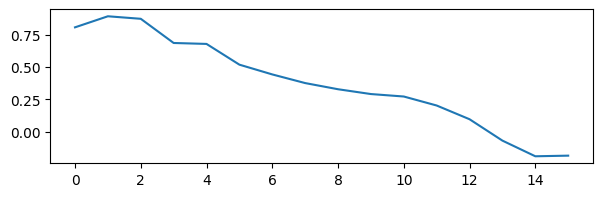

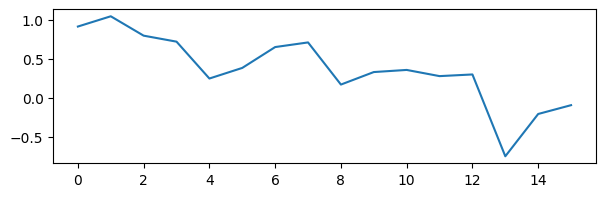

In [100]:
plt.figure(figsize=(7, 2))
plt.plot(X_train.iloc[5,0], label = "Original")
plt.figure(figsize=(7, 2))
plt.plot(X_train_noised.iloc[5,0], label = "Noised")

 24%|██▍       | 12/50 [00:01<00:04,  9.44it/s]


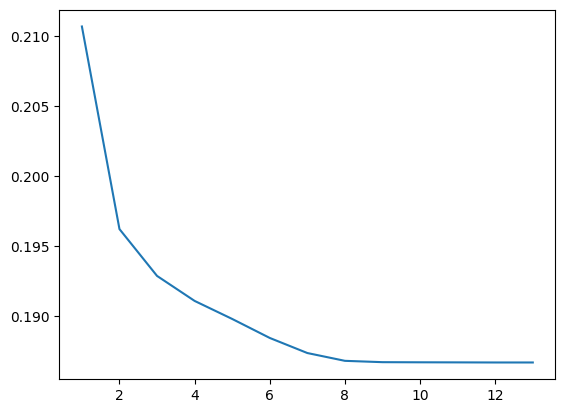

In [74]:
# add noise to X_train
X_train_noised = X_train + Epsilon

K = 9
p = 3
seuil = 1e-7
model = Mc2PCA(K, p, seuil, max_iter=50)
idx, E, info_by_cluster = model.fit(X_train_noised)
plt.plot(E)
plt.show()

Adjusted Rand Index: 0.2353967683005784
Precision: 0.5081081081081081
Recall: 0.4864864864864865


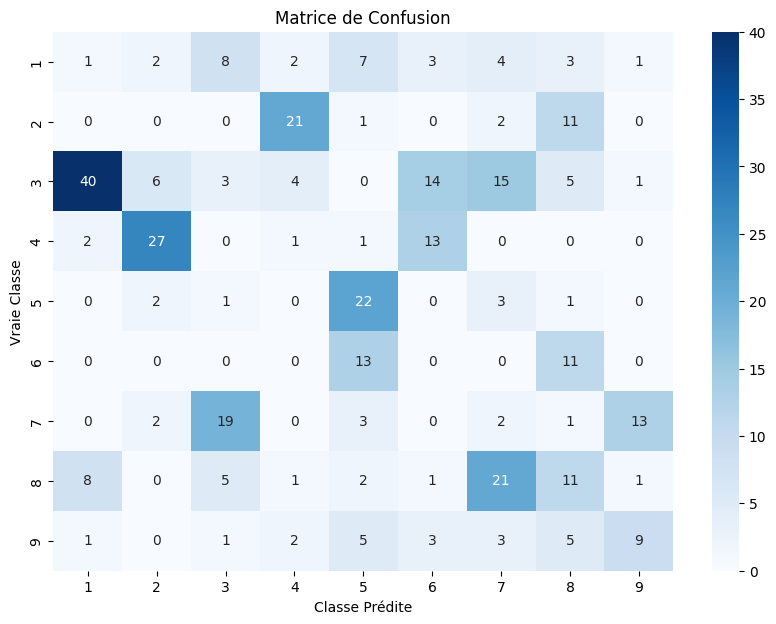

In [75]:
metrics(y_train, idx)

In [101]:
ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["fact","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])
for fact in [0,0.01,0.1,0.5,1,1.5,2,3]:
    print("fact:",fact)
    for i in range(20):
        X_test, y_test = load_japanese_vowels(return_X_y=True, split="train")
        X_train, y_train = load_japanese_vowels(return_X_y=True, split="test")
        np.random.seed(i)
        # shuffle rows
        X_train = X_train.sample(frac=1)
        y_train = y_train[X_train.index]

        Epsilon = np.empty_like(X_train)
        for i in range(Epsilon.shape[0]):
            for j in range(Epsilon.shape[1]):
                moy = X_train.iloc[i,j].mean()
                Epsilon[i, j] = moy*np.random.randn(len(X_train.iloc[i,j]))
        
        X_train_noised = X_train + fact*Epsilon

        K = 9
        p = 3
        seuil = 1e-7
        model = Mc2PCA(K, p, seuil, max_iter=50)
        idx, E, info_by_cluster = model.fit(X_train_noised)
        
        ari_score,precision,recall = metrics(y_train,idx)
        ari_scores.append(ari_score)
        precisions.append(precision)
        recalls.append(recall)

    df.loc[len(df)] = [fact,np.mean(ari_scores),np.std(ari_scores),np.mean(precisions),np.std(precisions),np.mean(recalls),np.std(recalls)]

print(df)

fact: 0


 40%|████      | 20/50 [00:02<00:03,  9.65it/s]


fact: 0.01


 56%|█████▌    | 28/50 [00:03<00:02,  7.61it/s]


fact: 0.1


 38%|███▊      | 19/50 [00:01<00:02, 10.92it/s]


fact: 0.5


 36%|███▌      | 18/50 [00:02<00:03,  8.56it/s]


fact: 1


 36%|███▌      | 18/50 [00:02<00:03,  8.00it/s]


fact: 1.5


 38%|███▊      | 19/50 [00:02<00:03,  7.88it/s]


fact: 2


 28%|██▊       | 14/50 [00:01<00:04,  7.84it/s]


fact: 3


 30%|███       | 15/50 [00:01<00:04,  7.92it/s]

   fact  ARI_mean   ARI_std  Precision_mean  Precision_std  Recall_mean  \
0  0.00  0.241394  0.038584        0.516081       0.029760     0.485405   
1  0.01  0.247304  0.036073        0.523446       0.029280     0.491284   
2  0.10  0.250483  0.037553        0.525721       0.033726     0.493829   
3  0.50  0.266521  0.047316        0.535135       0.038129     0.510574   
4  1.00  0.273947  0.049702        0.533000       0.039019     0.517919   
5  1.50  0.275688  0.047669        0.527005       0.040355     0.520518   
6  2.00  0.272924  0.045909        0.519556       0.042617     0.519595   
7  3.00  0.266996  0.047480        0.511250       0.046378     0.516706   

   Recall_std  
0    0.032639  
1    0.030154  
2    0.035056  
3    0.046002  
4    0.050578  
5    0.049328  
6    0.047950  
7    0.047356  


In [103]:
df.to_csv("results/results_sensivity.csv")